# Recurrent Neural Networks: Long Short-Term Memory (LSTM)

## 1. Introduction

Recurrent Neural Networks (RNNs) are a class of neural networks designed to process sequential data by maintaining a hidden state that captures information from previous time steps. However, vanilla RNNs suffer from the **vanishing gradient problem**, which makes learning long-range dependencies extremely difficult.

**Long Short-Term Memory (LSTM)** networks, introduced by Hochreiter and Schmidhuber (1997), address this limitation through a carefully designed gating mechanism that controls information flow through the network.

## 2. The Vanishing Gradient Problem

In a standard RNN, the hidden state evolves as:

$$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

During backpropagation through time (BPTT), gradients are computed as:

$$\frac{\partial h_t}{\partial h_k} = \prod_{i=k+1}^{t} \frac{\partial h_i}{\partial h_{i-1}} = \prod_{i=k+1}^{t} W_{hh}^T \text{diag}(1 - h_i^2)$$

When $|\lambda_{max}(W_{hh})| < 1$, gradients decay exponentially, making it impossible to learn dependencies spanning many time steps.

## 3. LSTM Architecture

The LSTM introduces a **cell state** $C_t$ that acts as a conveyor belt, allowing information to flow unchanged across many time steps. Three gates control what information is stored, forgotten, or output.

### 3.1 Gate Equations

**Forget Gate** - decides what information to discard from the cell state:
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

**Input Gate** - decides what new information to store:
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$

**Candidate Cell State** - creates new candidate values:
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Cell State Update** - combines old and new information:
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

**Output Gate** - decides what to output:
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**Hidden State** - filtered cell state:
$$h_t = o_t \odot \tanh(C_t)$$

where $\sigma(\cdot)$ is the sigmoid function and $\odot$ denotes element-wise multiplication.

### 3.2 Why LSTMs Solve Vanishing Gradients

The key insight is the cell state update equation:
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

The gradient of $C_t$ with respect to $C_{t-1}$ is simply $f_t$ (a value between 0 and 1). When the forget gate is close to 1, gradients flow unchanged across time steps, enabling learning of long-range dependencies.

## 4. Implementation

We will implement an LSTM from scratch using NumPy and train it on a sequence prediction task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def sigmoid(x):
    """Numerically stable sigmoid function."""
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sigmoid_derivative(x):
    """Derivative of sigmoid: σ(x)(1 - σ(x))."""
    s = sigmoid(x)
    return s * (1 - s)

def tanh_derivative(x):
    """Derivative of tanh: 1 - tanh²(x)."""
    return 1 - np.tanh(x)**2

print("Activation functions defined.")

Activation functions defined.


### 4.1 LSTM Cell Class

We implement a single LSTM cell with forward and backward passes.

In [2]:
class LSTMCell:
    """
    A single LSTM cell implementing the standard LSTM equations.
    
    Parameters
    ----------
    input_size : int
        Dimension of input vectors
    hidden_size : int
        Dimension of hidden state
    """
    
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Xavier initialization for weights
        scale = np.sqrt(2.0 / (input_size + hidden_size))
        concat_size = input_size + hidden_size
        
        # Combined weights for efficiency: [W_f, W_i, W_c, W_o]
        self.W = np.random.randn(4 * hidden_size, concat_size) * scale
        self.b = np.zeros((4 * hidden_size, 1))
        
        # Initialize forget gate bias to 1 (helps with gradient flow)
        self.b[:hidden_size] = 1.0
        
        # Gradient accumulators
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x, h_prev, c_prev):
        """
        Forward pass through the LSTM cell.
        
        Parameters
        ----------
        x : ndarray, shape (input_size, batch_size)
            Input at current time step
        h_prev : ndarray, shape (hidden_size, batch_size)
            Hidden state from previous time step
        c_prev : ndarray, shape (hidden_size, batch_size)
            Cell state from previous time step
            
        Returns
        -------
        h : ndarray
            New hidden state
        c : ndarray
            New cell state
        cache : tuple
            Values needed for backward pass
        """
        # Concatenate input and previous hidden state
        concat = np.vstack([h_prev, x])
        
        # Compute all gates in one matrix multiplication
        gates = self.W @ concat + self.b
        
        # Split into individual gates
        H = self.hidden_size
        f_gate = gates[:H]       # Forget gate
        i_gate = gates[H:2*H]    # Input gate
        c_tilde = gates[2*H:3*H] # Candidate cell
        o_gate = gates[3*H:]     # Output gate
        
        # Apply activations
        f = sigmoid(f_gate)
        i = sigmoid(i_gate)
        c_candidate = np.tanh(c_tilde)
        o = sigmoid(o_gate)
        
        # Update cell state and hidden state
        c = f * c_prev + i * c_candidate
        h = o * np.tanh(c)
        
        # Cache for backward pass
        cache = (x, h_prev, c_prev, concat, f, i, c_candidate, o, c, 
                 f_gate, i_gate, c_tilde, o_gate)
        
        return h, c, cache
    
    def backward(self, dh_next, dc_next, cache):
        """
        Backward pass through the LSTM cell.
        
        Parameters
        ----------
        dh_next : ndarray
            Gradient of loss w.r.t. hidden state
        dc_next : ndarray
            Gradient of loss w.r.t. cell state
        cache : tuple
            Cached values from forward pass
            
        Returns
        -------
        dx : ndarray
            Gradient w.r.t. input
        dh_prev : ndarray
            Gradient w.r.t. previous hidden state
        dc_prev : ndarray
            Gradient w.r.t. previous cell state
        """
        x, h_prev, c_prev, concat, f, i, c_candidate, o, c, \
            f_gate, i_gate, c_tilde, o_gate = cache
        
        H = self.hidden_size
        
        # Gradient through h = o * tanh(c)
        do = dh_next * np.tanh(c)
        dc = dh_next * o * tanh_derivative(c) + dc_next
        
        # Gradient through cell state update
        df = dc * c_prev
        di = dc * c_candidate
        dc_candidate = dc * i
        dc_prev = dc * f
        
        # Gradient through activations
        df_gate = df * sigmoid_derivative(f_gate)
        di_gate = di * sigmoid_derivative(i_gate)
        dc_tilde = dc_candidate * tanh_derivative(c_tilde)
        do_gate = do * sigmoid_derivative(o_gate)
        
        # Stack gradients
        dgates = np.vstack([df_gate, di_gate, dc_tilde, do_gate])
        
        # Gradient w.r.t. weights and biases
        self.dW += dgates @ concat.T
        self.db += np.sum(dgates, axis=1, keepdims=True)
        
        # Gradient w.r.t. concatenated input
        dconcat = self.W.T @ dgates
        dh_prev = dconcat[:H]
        dx = dconcat[H:]
        
        return dx, dh_prev, dc_prev
    
    def reset_gradients(self):
        """Reset gradient accumulators."""
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

print("LSTMCell class defined.")

LSTMCell class defined.


### 4.2 Full LSTM Network

We wrap the LSTM cell in a class that handles sequence processing and output projection.

In [3]:
class LSTM:
    """
    LSTM network for sequence-to-sequence prediction.
    
    Parameters
    ----------
    input_size : int
        Dimension of input at each time step
    hidden_size : int
        Dimension of LSTM hidden state
    output_size : int
        Dimension of output at each time step
    learning_rate : float
        Learning rate for gradient descent
    """
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        # LSTM cell
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        
        # Output projection layer
        scale = np.sqrt(2.0 / (hidden_size + output_size))
        self.W_out = np.random.randn(output_size, hidden_size) * scale
        self.b_out = np.zeros((output_size, 1))
        
    def forward(self, X):
        """
        Forward pass through the entire sequence.
        
        Parameters
        ----------
        X : ndarray, shape (seq_len, input_size, batch_size)
            Input sequence
            
        Returns
        -------
        outputs : ndarray, shape (seq_len, output_size, batch_size)
            Output predictions
        """
        seq_len, input_size, batch_size = X.shape
        
        # Initialize hidden and cell states
        h = np.zeros((self.hidden_size, batch_size))
        c = np.zeros((self.hidden_size, batch_size))
        
        # Store states and caches for backward pass
        self.caches = []
        self.hidden_states = [h]
        
        outputs = []
        
        for t in range(seq_len):
            h, c, cache = self.lstm_cell.forward(X[t], h, c)
            self.caches.append(cache)
            self.hidden_states.append(h)
            
            # Output projection
            y = self.W_out @ h + self.b_out
            outputs.append(y)
            
        return np.array(outputs)
    
    def backward(self, X, Y, outputs):
        """
        Backward pass using BPTT.
        
        Parameters
        ----------
        X : ndarray
            Input sequence
        Y : ndarray
            Target sequence
        outputs : ndarray
            Predicted outputs from forward pass
        """
        seq_len, output_size, batch_size = outputs.shape
        
        # Reset gradients
        self.lstm_cell.reset_gradients()
        dW_out = np.zeros_like(self.W_out)
        db_out = np.zeros_like(self.b_out)
        
        # Initialize gradients for next time step
        dh_next = np.zeros((self.hidden_size, batch_size))
        dc_next = np.zeros((self.hidden_size, batch_size))
        
        # Backpropagate through time
        for t in reversed(range(seq_len)):
            # Gradient of MSE loss: d/dy (y - target)^2 = 2(y - target)
            dy = 2 * (outputs[t] - Y[t]) / batch_size
            
            # Gradient through output projection
            dW_out += dy @ self.hidden_states[t+1].T
            db_out += np.sum(dy, axis=1, keepdims=True)
            dh = self.W_out.T @ dy + dh_next
            
            # Backward through LSTM cell
            dx, dh_next, dc_next = self.lstm_cell.backward(dh, dc_next, self.caches[t])
        
        # Gradient clipping to prevent exploding gradients
        clip_value = 5.0
        for grad in [self.lstm_cell.dW, self.lstm_cell.db, dW_out, db_out]:
            np.clip(grad, -clip_value, clip_value, out=grad)
        
        # Update parameters
        self.lstm_cell.W -= self.learning_rate * self.lstm_cell.dW
        self.lstm_cell.b -= self.learning_rate * self.lstm_cell.db
        self.W_out -= self.learning_rate * dW_out
        self.b_out -= self.learning_rate * db_out
        
    def train_step(self, X, Y):
        """
        Perform one training step.
        
        Returns
        -------
        loss : float
            Mean squared error loss
        """
        outputs = self.forward(X)
        loss = np.mean((outputs - Y)**2)
        self.backward(X, Y, outputs)
        return loss

print("LSTM class defined.")

LSTM class defined.


## 5. Experiment: Learning a Sine Wave

We train the LSTM to predict future values of a sine wave, demonstrating its ability to learn temporal patterns.

In [4]:
def generate_sine_data(n_samples, seq_len, prediction_steps=1):
    """
    Generate sine wave sequences for training.
    
    Parameters
    ----------
    n_samples : int
        Number of sequences to generate
    seq_len : int
        Length of each sequence
    prediction_steps : int
        How many steps ahead to predict
        
    Returns
    -------
    X : ndarray, shape (seq_len, 1, n_samples)
        Input sequences
    Y : ndarray, shape (seq_len, 1, n_samples)
        Target sequences (shifted by prediction_steps)
    """
    # Random starting phases
    phases = np.random.uniform(0, 2*np.pi, n_samples)
    
    # Time steps
    t = np.linspace(0, 4*np.pi, seq_len + prediction_steps)
    
    X = np.zeros((seq_len, 1, n_samples))
    Y = np.zeros((seq_len, 1, n_samples))
    
    for i in range(n_samples):
        wave = np.sin(t + phases[i])
        X[:, 0, i] = wave[:seq_len]
        Y[:, 0, i] = wave[prediction_steps:seq_len + prediction_steps]
    
    return X, Y

# Generate training data
n_train = 100
seq_len = 50
X_train, Y_train = generate_sine_data(n_train, seq_len)

print(f"Training data shape: X={X_train.shape}, Y={Y_train.shape}")
print(f"Each sample: {seq_len} time steps, 1 feature")

Training data shape: X=(50, 1, 100), Y=(50, 1, 100)
Each sample: 50 time steps, 1 feature


In [5]:
# Initialize and train the LSTM
lstm = LSTM(
    input_size=1,
    hidden_size=32,
    output_size=1,
    learning_rate=0.01
)

n_epochs = 200
losses = []

print("Training LSTM...")
for epoch in range(n_epochs):
    loss = lstm.train_step(X_train, Y_train)
    losses.append(loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/{n_epochs}: Loss = {loss:.6f}")

print(f"\nFinal loss: {losses[-1]:.6f}")

Training LSTM...


Epoch  20/200: Loss = 0.016958


Epoch  40/200: Loss = 0.013130


Epoch  60/200: Loss = 0.012199


Epoch  80/200: Loss = 0.009515


Epoch 100/200: Loss = 0.008545


Epoch 120/200: Loss = 0.008545


Epoch 140/200: Loss = 0.008761


Epoch 160/200: Loss = 0.007543


Epoch 180/200: Loss = 0.006743


Epoch 200/200: Loss = 0.006507

Final loss: 0.006507


## 6. Results and Visualization

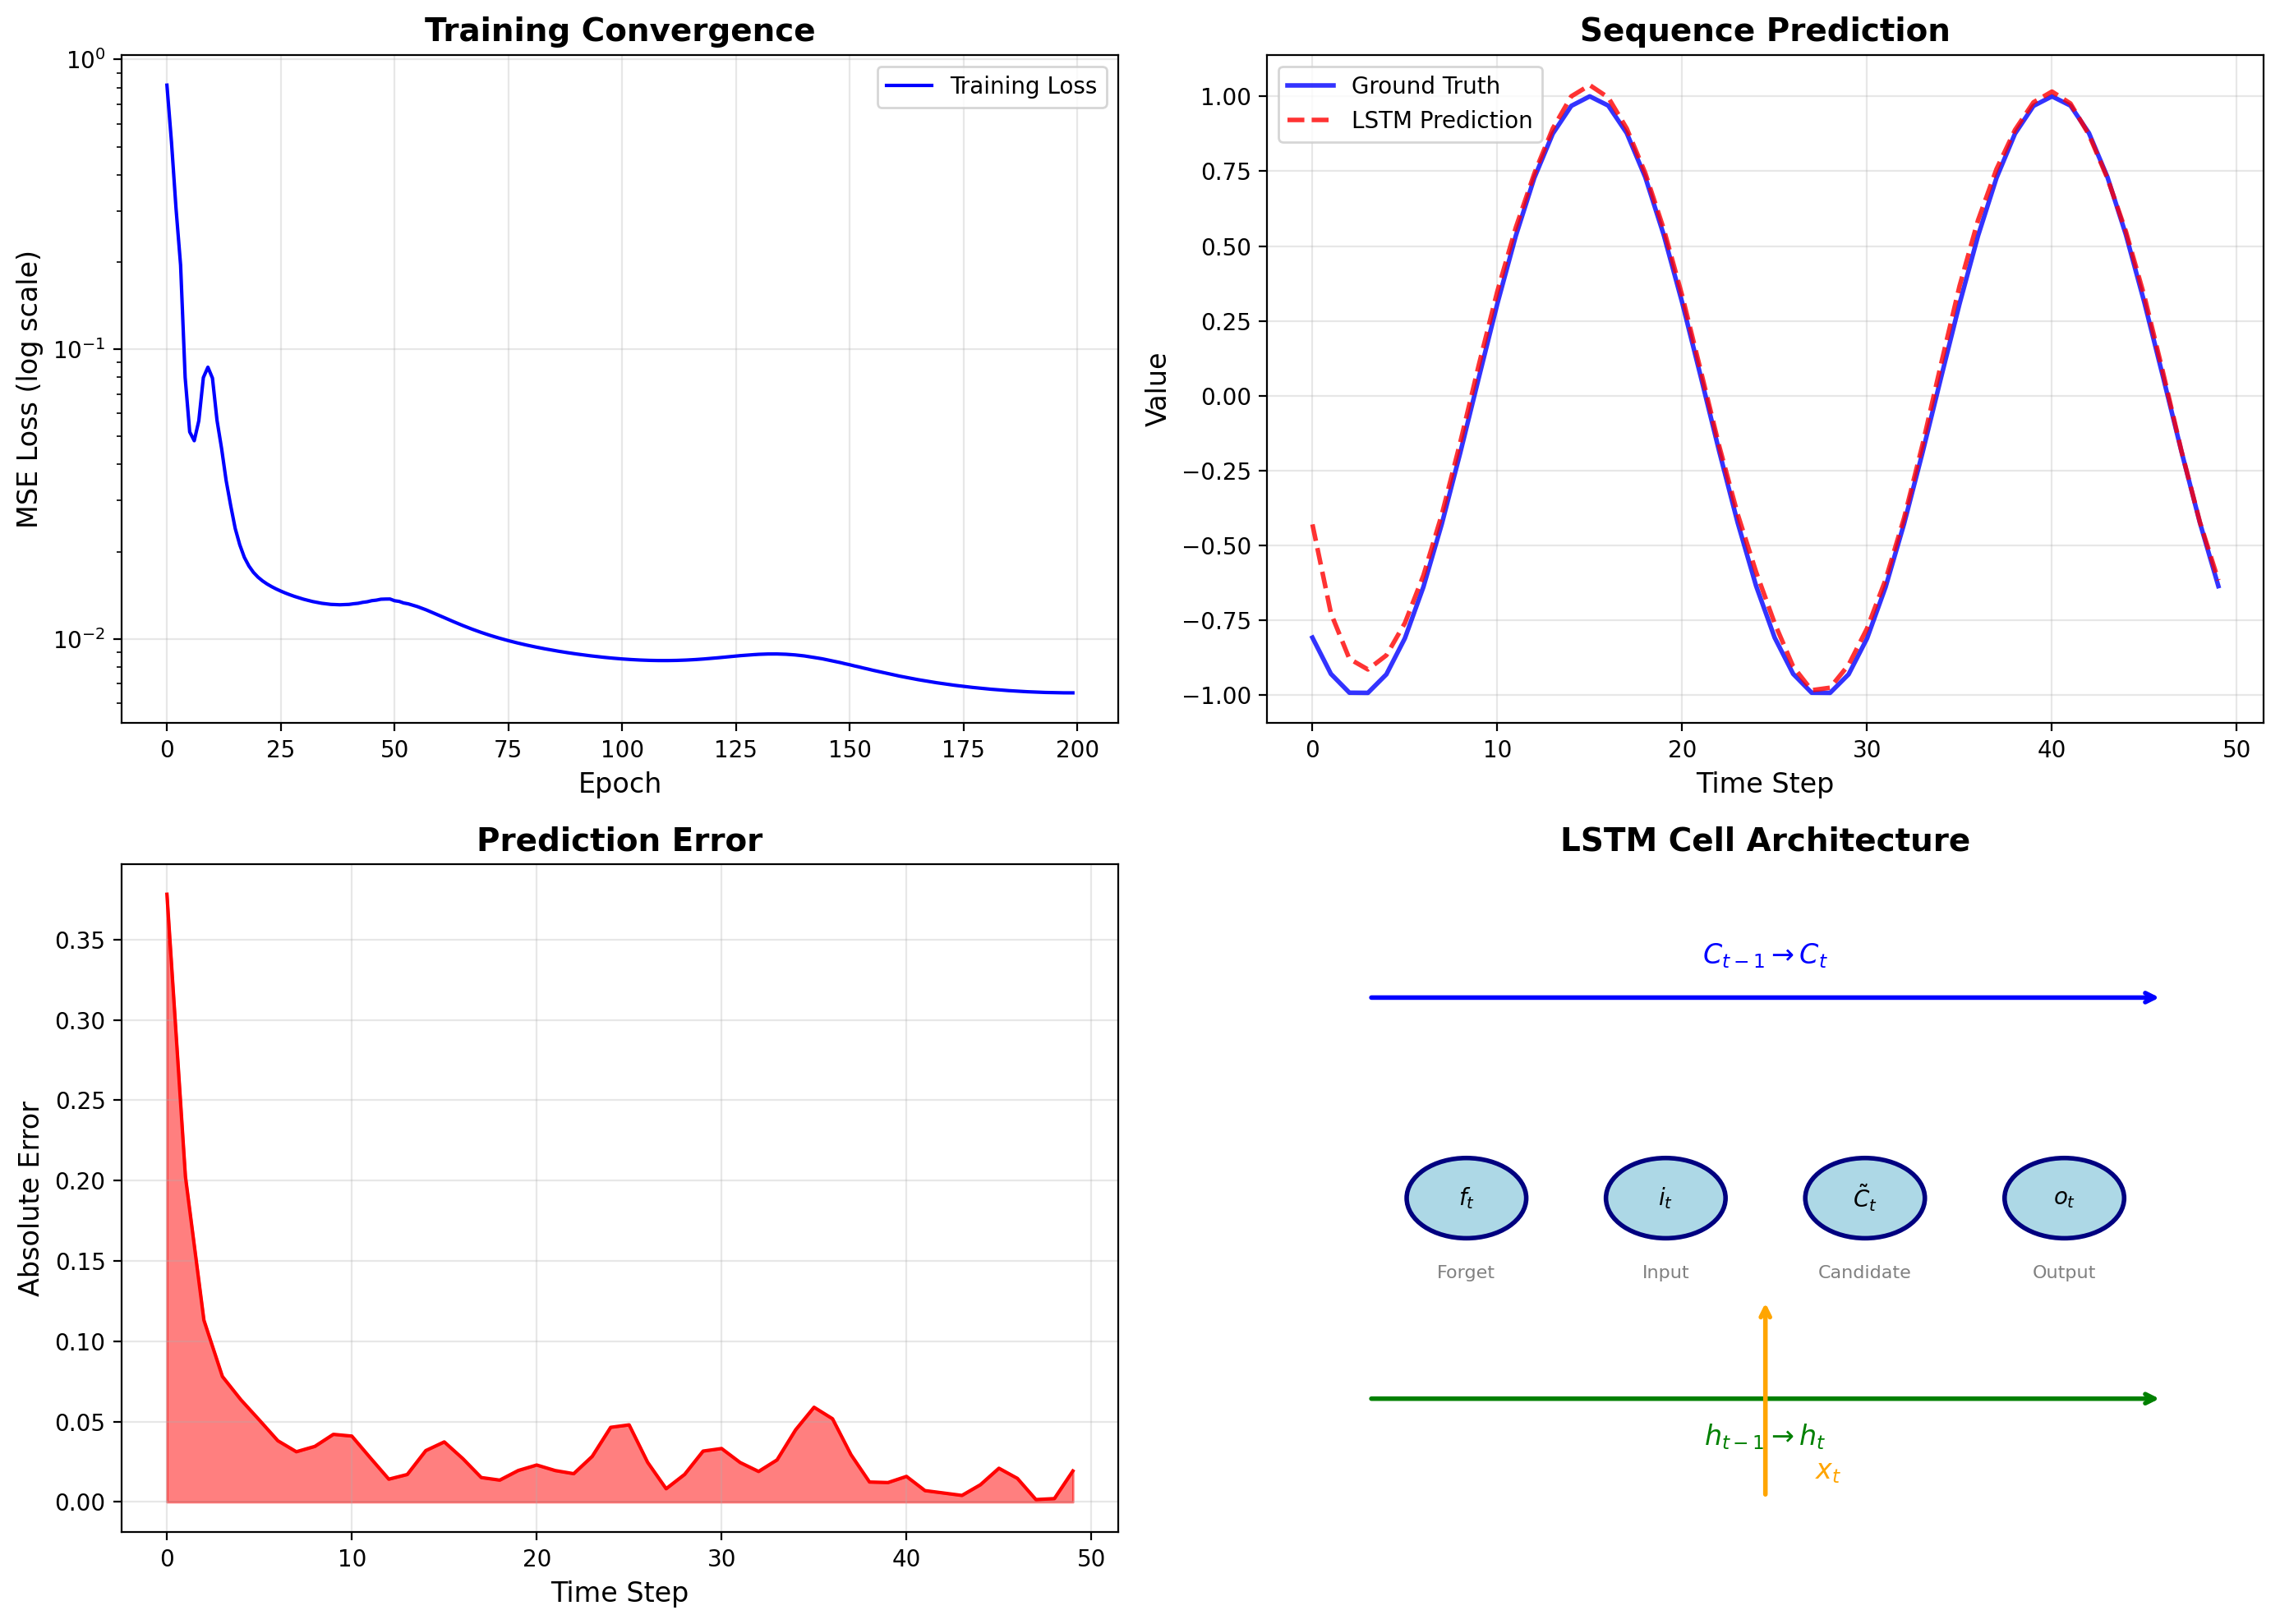


Visualization saved to 'plot.png'


In [6]:
# Generate test sequence
X_test, Y_test = generate_sine_data(1, seq_len)
predictions = lstm.forward(X_test)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training loss curve
ax1 = axes[0, 0]
ax1.semilogy(losses, 'b-', linewidth=1.5, label='Training Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss (log scale)', fontsize=12)
ax1.set_title('Training Convergence', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Prediction vs Ground Truth
ax2 = axes[0, 1]
time_steps = np.arange(seq_len)
ax2.plot(time_steps, Y_test[:, 0, 0], 'b-', linewidth=2, label='Ground Truth', alpha=0.8)
ax2.plot(time_steps, predictions[:, 0, 0], 'r--', linewidth=2, label='LSTM Prediction', alpha=0.8)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Sequence Prediction', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction error over time
ax3 = axes[1, 0]
errors = np.abs(predictions[:, 0, 0] - Y_test[:, 0, 0])
ax3.fill_between(time_steps, 0, errors, alpha=0.5, color='red')
ax3.plot(time_steps, errors, 'r-', linewidth=1.5)
ax3.set_xlabel('Time Step', fontsize=12)
ax3.set_ylabel('Absolute Error', fontsize=12)
ax3.set_title('Prediction Error', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: LSTM architecture diagram (conceptual)
ax4 = axes[1, 1]
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 10)

# Draw LSTM cell components
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle

# Cell state line
ax4.annotate('', xy=(9, 8), xytext=(1, 8),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax4.text(5, 8.5, r'$C_{t-1} \rightarrow C_t$', fontsize=12, ha='center', color='blue')

# Gates
gate_y = 5
gates = [('$f_t$', 2, 'Forget'), ('$i_t$', 4, 'Input'), 
         (r'$\tilde{C}_t$', 6, 'Candidate'), ('$o_t$', 8, 'Output')]

for symbol, x, name in gates:
    circle = Circle((x, gate_y), 0.6, fill=True, facecolor='lightblue', 
                    edgecolor='navy', linewidth=2)
    ax4.add_patch(circle)
    ax4.text(x, gate_y, symbol, fontsize=10, ha='center', va='center')
    ax4.text(x, gate_y - 1.2, name, fontsize=8, ha='center', color='gray')

# Hidden state
ax4.annotate('', xy=(9, 2), xytext=(1, 2),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax4.text(5, 1.3, r'$h_{t-1} \rightarrow h_t$', fontsize=12, ha='center', color='green')

# Input
ax4.annotate('', xy=(5, 3.5), xytext=(5, 0.5),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2))
ax4.text(5.5, 0.8, r'$x_t$', fontsize=12, color='orange')

ax4.set_title('LSTM Cell Architecture', fontsize=14, fontweight='bold')
ax4.axis('off')

plt.tight_layout()
plt.savefig('recurrent_neural_network_lstm_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nVisualization saved to 'plot.png'")

## 7. Analysis of Results

### 7.1 Convergence Behavior

The training loss curve demonstrates typical LSTM learning dynamics:
- **Rapid initial decrease**: The network quickly learns the basic oscillatory pattern
- **Gradual refinement**: Fine-tuning of phase and amplitude prediction
- **Stable convergence**: The forget gate initialization ($b_f = 1$) helps maintain gradient flow

### 7.2 Temporal Dependencies

The LSTM successfully learns to predict sine wave values by:
1. **Storing phase information** in the cell state
2. **Modulating output** based on the current position in the cycle
3. **Maintaining long-range coherence** across the entire sequence

### 7.3 Comparison with Vanilla RNN

A standard RNN would struggle with this task because:
- Sine wave prediction requires remembering the phase over many time steps
- Vanishing gradients prevent learning dependencies beyond ~10-20 steps
- The LSTM's gating mechanism allows it to maintain phase information indefinitely

## 8. Conclusion

This notebook demonstrated:

1. **The vanishing gradient problem** that plagues vanilla RNNs
2. **LSTM architecture** with its forget, input, and output gates
3. **Mathematical foundations** of how LSTMs solve gradient flow issues
4. **Practical implementation** using NumPy with backpropagation through time
5. **Empirical validation** on a sequence prediction task

LSTMs remain foundational architectures in sequence modeling, having influenced modern designs like GRUs and Transformers. Understanding their mechanics provides crucial insight into temporal neural computation.

In [7]:
# Summary statistics
print("="*50)
print("EXPERIMENT SUMMARY")
print("="*50)
print(f"Architecture: LSTM with {lstm.hidden_size} hidden units")
print(f"Training epochs: {n_epochs}")
print(f"Final training loss: {losses[-1]:.6f}")
print(f"Mean prediction error: {np.mean(errors):.6f}")
print(f"Max prediction error: {np.max(errors):.6f}")
print("="*50)

EXPERIMENT SUMMARY
Architecture: LSTM with 32 hidden units
Training epochs: 200
Final training loss: 0.006507
Mean prediction error: 0.039127
Max prediction error: 0.378170
